In [1]:
from pathlib import Path
import os
import sys
import shutil
import numpy as np
import time
import datetime
import numpy as np
import torch
import torch.nn as nn
import torchvision
import cfg
from torchvision.utils import save_image, make_grid

from types import SimpleNamespace
import json

from models.ResNet import Res12_Quadratic, Res18_Quadratic, Res34_Quadratic
from functions.sampling import Langevin_E, SS_denoise,  Annealed_Langevin_E,Reverse_AIS_sampling,AIS_sampling
from functions.analysis import save_sample_pdf

In [2]:
# save_folder = 'fastmri_EBM_2024_May14_16_25'

# save_folder = 'fastmri_EBM_2024_May15_08_38'

# save_folder = 'fastmri_EBM_2024_May23_22_46'

# settings_fname = '/settings.json'

save_folder = 'fastmri_EBM_2024_May29_16_13'
settings_fname = '/settings_2024_May30_09_39.json'

root = 'logs/' + save_folder
with open(root + settings_fname, "r", encoding='utf8') as sf:
    settings = json.load(sf)

In [3]:
args = SimpleNamespace()
args.__dict__.update(settings)
args.__dict__

{'n_iter': 25000,
 'num_sub': 50,
 'res': 64,
 'classes': [0],
 'batch_size': 128,
 'in_chan': 1,
 'n_chan': 128,
 'n_gpus': 1,
 'max_lr': 5e-05,
 'min_noise': 0.1,
 'max_noise': 3.0,
 'noise_distribution': 'exp',
 'save_every': 1000,
 'dataset': 'fastmri',
 'log': 'fastmri_EBM',
 'cont': True,
 'time': '2024_May29_16_13',
 'net_indx': 25000,
 'lr_schedule': 'cosine',
 'rand_seed': 42,
 'file_name': 'mdsm_ebm',
 'net': 'res34'}

In [4]:
# args.net_indx = 266000    # fastmri_EBM_2024_May15_08_38

# args.net_indx = 14000    # fastmri_EBM_2024_May23_22_46

args.net_indx = 125000    # fastmri_EBM_2024_May29_16_13

In [5]:
args.sample_batch_size = 256
args.annealing_schedule = 'exp'
args.sample_step_size = 0.01

Nsampling = 2000
Tmax, Tmin = 100, 0.1
flat_start_steps, flat_end_steps = 500, 500
init_noise_mean = 0.5
final_denoise_sigma = 0.05

In [6]:
torch.cuda.empty_cache()
torch.cuda.manual_seed(args.rand_seed)

sample_x = torch.zeros((args.sample_batch_size,1,args.res,args.res))

if args.net == 'res34':
    netE = Res34_Quadratic(args.in_chan,args.n_chan,32,normalize=False,AF=nn.ELU())
else:
    netE = Res18_Quadratic(args.in_chan,args.n_chan,32,normalize=False,AF=nn.ELU())

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netE = netE.to(device)
if args.n_gpus > 1:
    netE = nn.DataParallel(netE)

In [8]:
if args.annealing_schedule =='exp':
    # exponential schedule with flat region in the beginning and end
    T = Tmax*np.exp(-np.linspace(0,Nsampling-1,Nsampling)*(np.log(Tmax/Tmin)/Nsampling))
    T = np.concatenate((Tmax*np.ones((flat_start_steps,)),T),axis=0)
    T = np.concatenate((T,Tmin*np.linspace(1,0,flat_end_steps)),axis=0)

elif args.annealing_schedule == 'lin':
    # linear schedule with flat region in the beginning and end
    T = np.linspace(Tmax,Tmin,Nsampling)
    T = np.concatenate((Tmax*np.ones((flat_start_steps,)),T),axis=0)
    T = np.concatenate((T,Tmin*np.linspace(1,0,flat_end_steps)),axis=0)

In [9]:
filename = args.file_name + str(args.net_indx) + '.pt'
netE.load_state_dict(torch.load(root + '/models/'+filename))

print(f'generating {args.sample_batch_size} samples for {filename}')

initial_x = init_noise_mean + torch.randn_like(sample_x).to(device)
x_list,E_trace = Annealed_Langevin_E(netE,initial_x,args.sample_step_size,T,100)
print(str(len(x_list)))

x_last = SS_denoise(x_list[-1].to(device),netE,0.0)
x_denoise = SS_denoise(x_list[-1].to(device),netE, final_denoise_sigma)

generating 256 samples for mdsm_ebm125000.pt
langevin step 100/3000
langevin step 200/3000
langevin step 300/3000
langevin step 400/3000
langevin step 500/3000
langevin step 600/3000
langevin step 700/3000
langevin step 800/3000
langevin step 900/3000
langevin step 1000/3000
langevin step 1100/3000
langevin step 1200/3000
langevin step 1300/3000
langevin step 1400/3000
langevin step 1500/3000
langevin step 1600/3000
langevin step 1700/3000
langevin step 1800/3000
langevin step 1900/3000
langevin step 2000/3000
langevin step 2100/3000
langevin step 2200/3000
langevin step 2300/3000
langevin step 2400/3000
langevin step 2500/3000
langevin step 2600/3000
langevin step 2700/3000
langevin step 2800/3000
langevin step 2900/3000
langevin step 3000/3000
30


In [10]:
sq = int(np.ceil(np.sqrt(args.sample_batch_size)))
vmax = 0.7
save_sample_pdf(x_last[0:args.sample_batch_size],(sq,sq),root + f'/samples/{args.dataset}_{args.annealing_schedule}_{args.sample_batch_size}samples_{args.net_indx}iter.pdf', vmax=vmax)
# save_sample_pdf(x_denoise[0:args.sample_batch_size],(sq,sq),root + f'/samples/{args.dataset}_{args.annealing_schedule}_{args.sample_batch_size}samples_{args.net_indx}iter_denoise{final_denoise_sigma}.pdf', vmax=vmax)

<Figure size 1058x1058 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def plot_sample(samples,grid_size,pad=2,vmax=1.0):
    #samples should be a torch tensor
    [Nsamples,Nchannels,Size_x,Size_y] = samples.shape
    
    
    last_step_denoise = make_grid(samples,normalize=False,nrow=grid_size[1],padding=pad).detach().cpu().numpy()
    last_step_denoise = np.moveaxis(last_step_denoise,0,2)
    
    n = colors.Normalize(vmin=0,vmax=vmax,clip=True)
    normalized=n(last_step_denoise)
    n_pix_column = grid_size[0]*Size_y + (grid_size[0]+1)*pad
    n_pix_row = grid_size[1]*Size_x + (grid_size[1]+1)*pad
    plt.figure(figsize=(n_pix_row/100*2,n_pix_column/100*2), dpi=100)
    plt.imshow(normalized, vmin=0, vmax=vmax)
    plt.axis('off')
    plt.show()

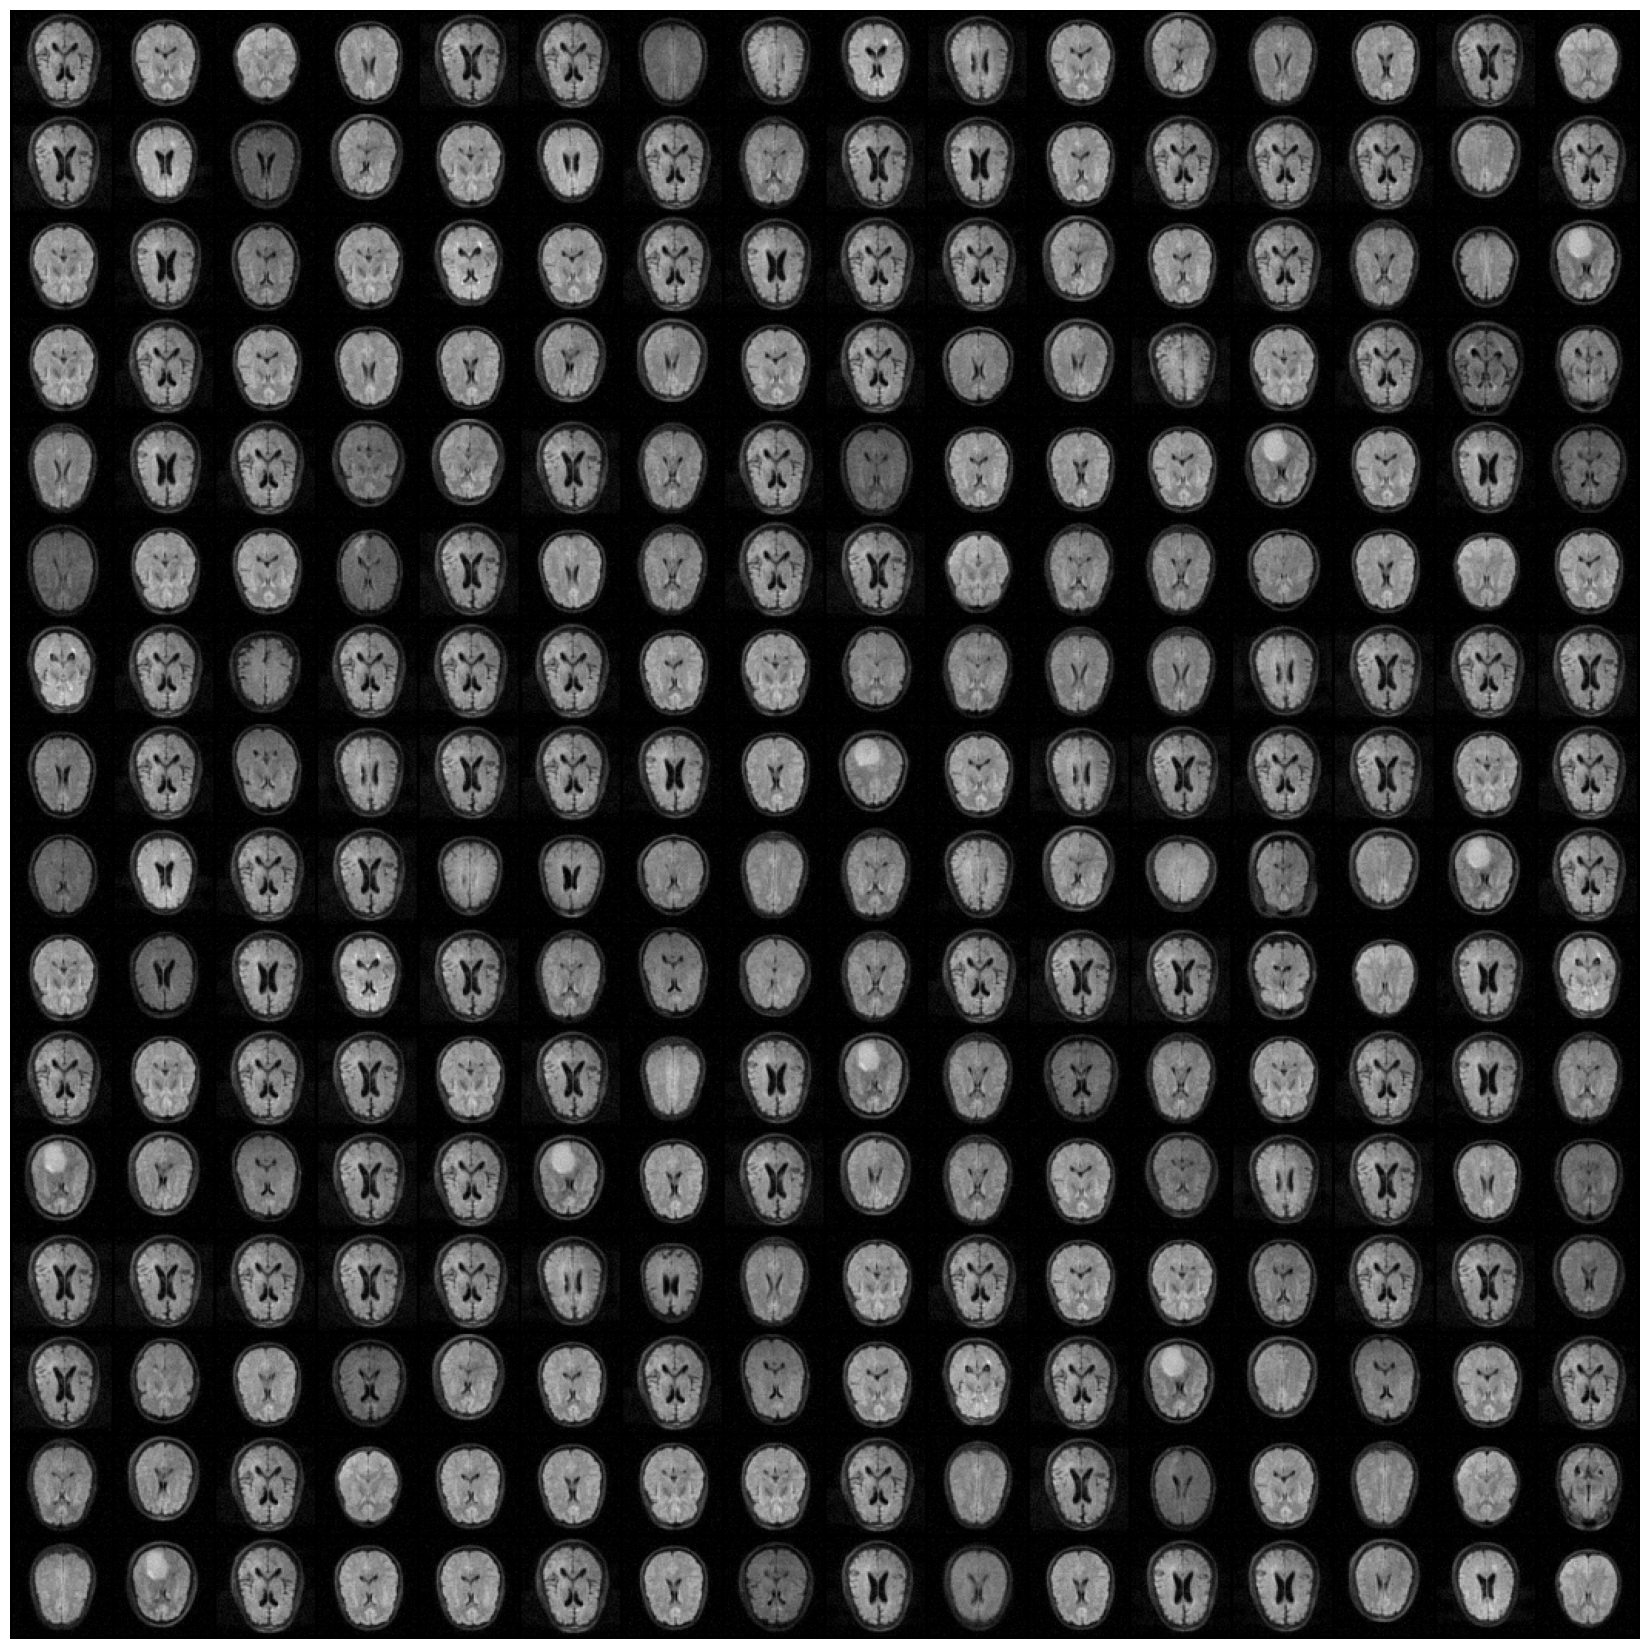

In [12]:
plot_sample(x_last[0:args.sample_batch_size],(sq,sq),vmax=0.7)

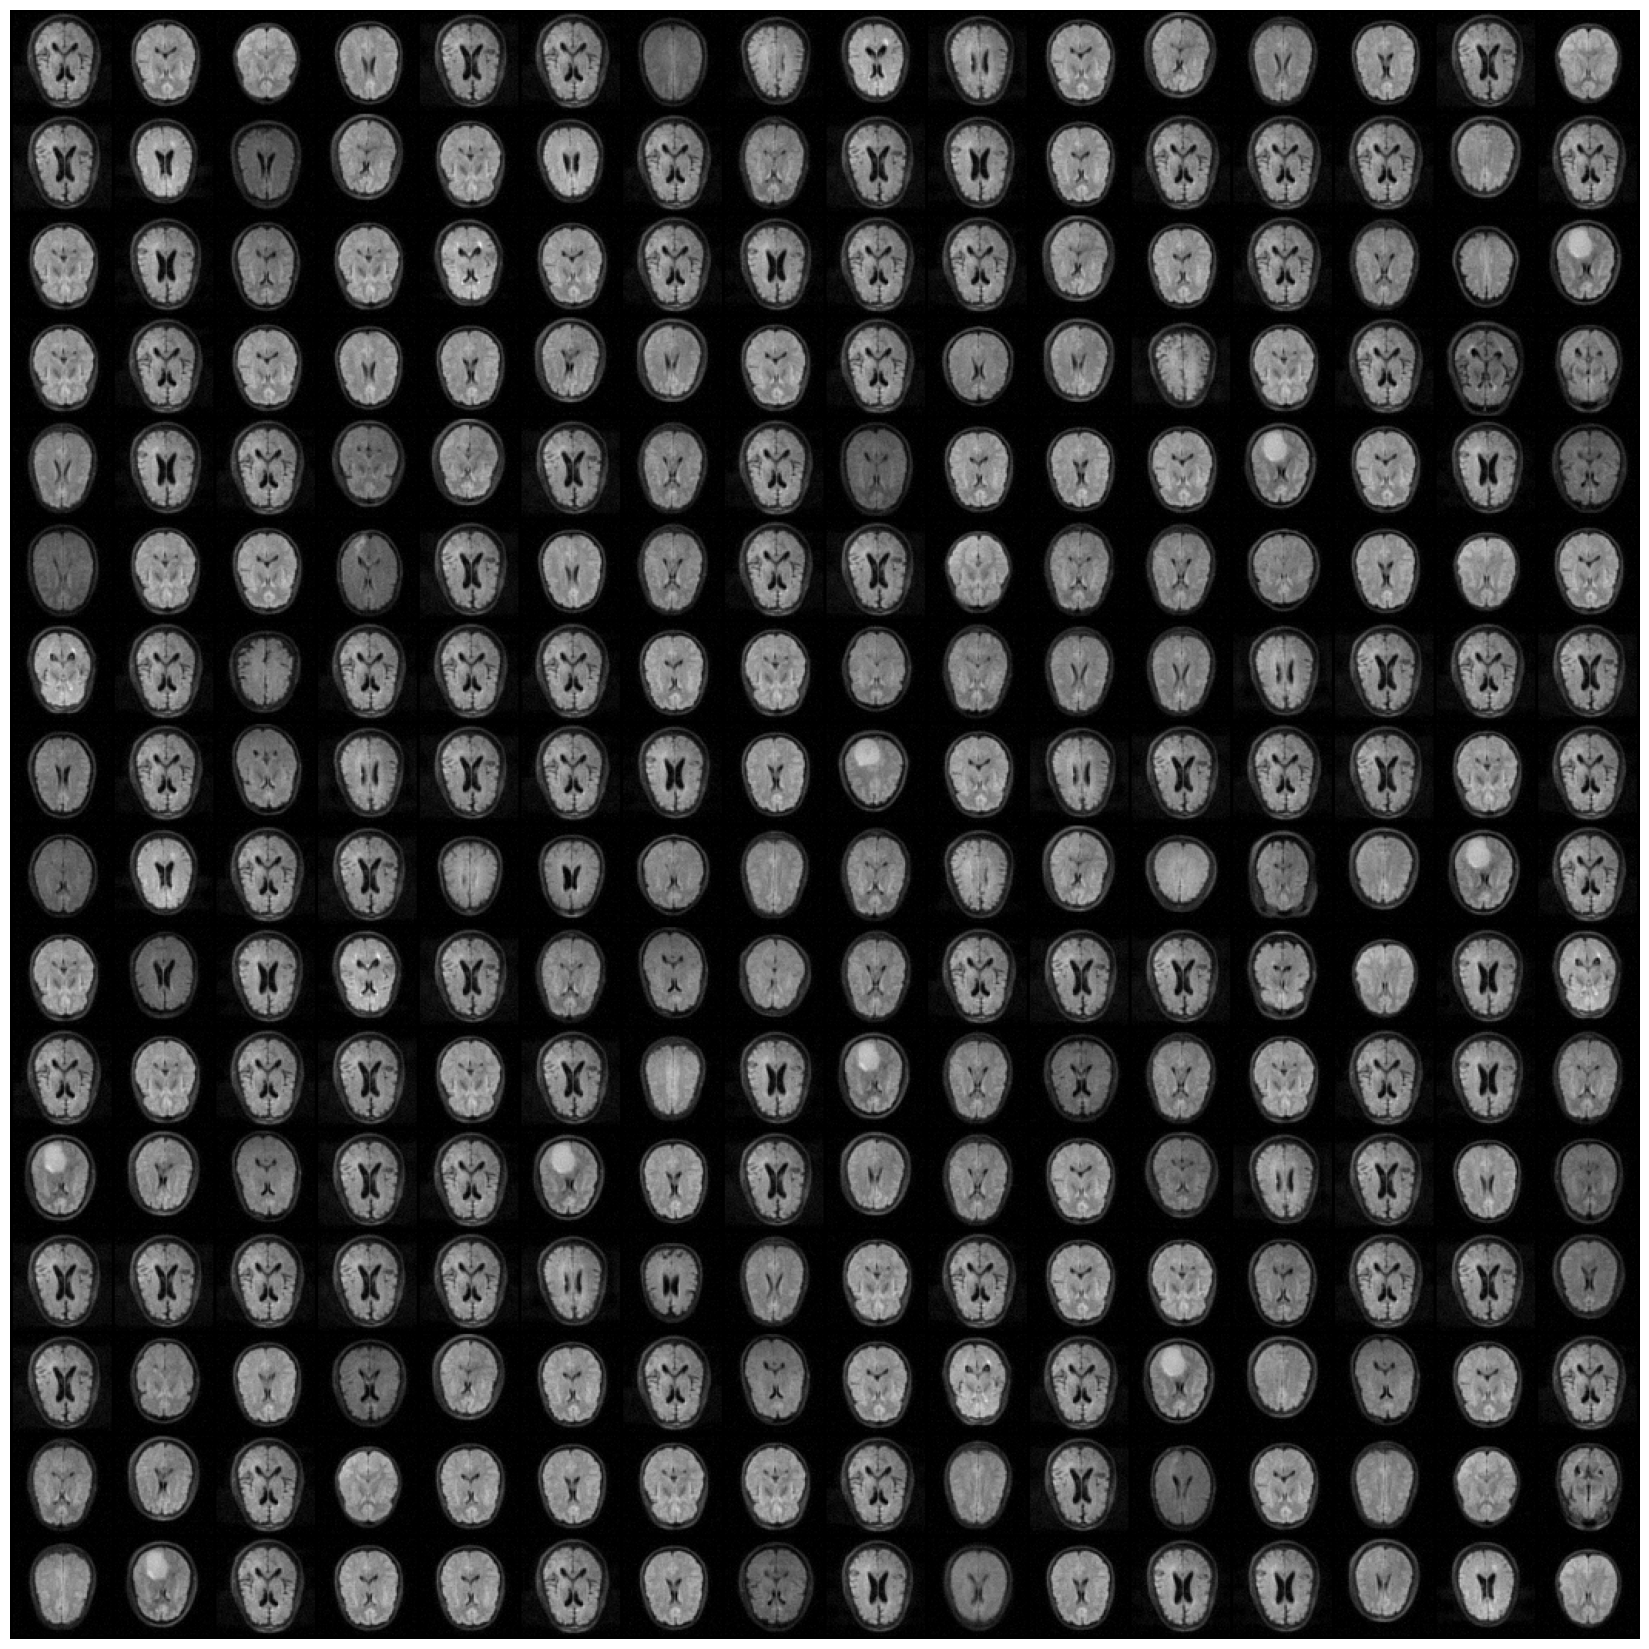

In [13]:
plot_sample(x_denoise[0:args.sample_batch_size],(sq,sq),vmax=0.7)